In [384]:
import numpy as np
import pandas as pd
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import time
from astropy.coordinates import GeocentricMeanEcliptic
from astropy.coordinates import HeliocentricMeanEcliptic
from astropy.coordinates import HeliocentricTrueEcliptic
from astropy.coordinates import GeocentricTrueEcliptic

#This function takes a parameter Dataframe in RA/DEC, and converts it to Latitude and Longitude, while also converting the dates to Primary-Centric Julian dates
def convert_to_primary_centric(paramsDF,objectName):
    columnList = list(paramsDF)
    
    #Current column names are just descriptive, not representative of final product column names
    updatedDF = pd.DataFrame(columns = ['Primary-Centric Time','Delta_lon','Delta_lat'])
    
    #Convert the dates into a Julian date format
    date = paramsDF['Dates']
    dateList = []
    for i in date:
        jd = Time(i,format='jd')
        dateList.append(jd)
        
    #Get the Horizons data for the object at the times it was observed
    primary = Horizons(id=objectName,location=None,epochs=dateList)
    
    updatedDF['Primary-Centric Time'] = paramsDF['Dates']-primary.vectors()['lighttime']
    
    
    #First, put the values in the dataframe into numpy arrays. Currently using the Grundy data for MakeMake
    deltaRA = np.array(paramsDF['Delta-RA'])
    deltaDEC = np.array(paramsDF['Delta-DEC'])
    RA_primary = np.array(paramsDF['RA-Primary'])
    DEC_primary = np.array(paramsDF['DEC-Primary'])
    RA_obj = RA_primary+deltaRA/3600
    DEC_obj = DEC_primary+deltaDEC/3600
    
    #Essentially we define where the object is in our RA/DEC coordinate system. ICRS is the system our coordinates are in.
    #dist = primary.vectors()['delta']
    moonC = SkyCoord(ra=RA_obj*u.degree, dec=DEC_obj*u.degree, frame='icrs')
    primC = SkyCoord(ra=RA_primary*u.degree, dec=DEC_primary*u.degree, frame='icrs')

    #This transformation takes the defined coordinate system, and converts it to the GeocentricMeanEcliptic coordinate system.
    
    
    moonEcl = moonC.transform_to(GeocentricTrueEcliptic(equinox='J2000'))
    primEcl = primC.transform_to(GeocentricTrueEcliptic(equinox='J2000'))
    
    #These are the positions of the moon relative to the primary
    updatedDF['Latitude_moon'] = moonEcl.lat.degree
    updatedDF['Longitude_moon'] = moonEcl.lon.degree
    
    #These are the positions of the primary
    updatedDF['Latitude_prim'] = primEcl.lat.degree
    updatedDF['Longitude_prim'] = primEcl.lon.degree
    
    #These are the positions of the moon relative to the primary using Grundy's Delta-lat and Delta-lon; Og = Original Gangster
    updatedDF['OGLat_moon']=np.array(updatedDF['Latitude_prim'])+np.array(paramsDF['Delta_lat'])/3600
    updatedDF['OGLon_moon']= np.array(updatedDF['Longitude_prim'])+np.array(paramsDF['Delta_lon'])/3600
    
    #Calculated Delta-lat and Delta lon from the RA and DEC's
    updatedDF['Delta_lat'] = (updatedDF['Latitude_prim']-updatedDF['Latitude_moon'])*3600
    updatedDF['Delta_lon'] = (updatedDF['Longitude_prim']-updatedDF['Longitude_moon'])*3600
    
    #We are just going to plot one iteration of the data
    lats = [np.array(updatedDF['Latitude_moon']),np.array(updatedDF['Latitude_prim']),np.array(updatedDF['OGLat_moon'])]
    longs = [np.array(updatedDF['Longitude_moon']),np.array(updatedDF['Longitude_prim']),np.array(updatedDF['OGLon_moon'])]
    lats = [i*3600 for i in lats]
    longs = [i*3600 for i in longs]

    #Plot the original RA and DEC of the moon and the deconstructed RA and DEC of the moon
    Lat_moon = np.array(updatedDF['Latitude_moon'])
    Lon_moon = np.array(updatedDF['Longitude_moon'])
    
    
    moonZ = SkyCoord(Lon_moon*u.degree,Lat_moon*u.degree, frame=GeocentricTrueEcliptic,equinox='J2000')
    moonRADEC = moonZ.transform_to('icrs')
    
    newMoonRA = moonRADEC.ra.degree
    newMoonDEC = moonRADEC.dec.degree
    
    s = ['m','M','P']
    hmm = np.array([newMoonRA,RA_obj,RA_primary])*3600
    umm = np.array([newMoonDEC,DEC_obj,DEC_primary])*3600
    print(hmm,umm)
    arr1x, arr1y = [hmm[0][0],hmm[1][0],hmm[2][0]],[umm[0][0],umm[1][0],umm[2][0]]
    arr2x, arr2y = [hmm[0][1],hmm[1][1],hmm[2][1]],[umm[0][1],umm[1][1],umm[2][1]]
    arr3x, arr3y = [hmm[0][2],hmm[1][2],hmm[2][2]],[umm[0][2],umm[1][2],umm[2][2]]
    arr4x, arr4y = [hmm[0][3],hmm[1][3],hmm[2][3]],[umm[0][3],umm[1][3],umm[2][3]]
    arr5x, arr5y = [hmm[0][4],hmm[1][4],hmm[2][4]],[umm[0][4],umm[1][4],umm[2][4]]
    
    plt.scatter(arr1x,arr1y,color=['red','blue','black'])
    plt.show()
    plt.scatter(arr2x,arr2y,color=['red','blue','black'])
    plt.scatter(arr3x,arr3y,color=['red','blue','black'])
    plt.scatter(arr4x,arr4y,color=['red','blue','black'])
    plt.scatter(arr5x,arr5y,color=['red','blue','black'])
    
    #plt.text((arr1x-0.08),(arr1y-0.04),s,fontsize=9)
    plt.show()
    
 
    #Plot the primary, and the moon's position based on calculation. Also plot the moon based on the original data's delta-lat and delta-lon
    
    def plot_scatter(array,dictionary, words):
        for i in words:
            x, y = array[dictionary[i]]
            plt.scatter(x, y, color = 'red')
            if dictionary[i]==2:
                plt.text(x-0.08,y-0.04,i,fontsize=9)
            else:
                plt.text(x+0.02,y+0.02,i,fontsize=9)
        plt.ylabel('Latitude')
        plt.xlabel('Longitude')
        plt.show()
    
    
    words = ['(Ra+D-Ra,Dec+D-Dec)','Primary','(Lon+D-Lon,Lat+D-Lat)']
    array1 = np.array([[longs[0][0],lats[0][0]],[longs[1][0],lats[1][0]],[longs[2][0],lats[2][0]]]) 
    array2 = np.array([[longs[0][1],lats[0][1]],[longs[1][1],lats[1][1]],[longs[2][1],lats[2][1]]]) 
    array3 = np.array([[longs[0][2],lats[0][2]],[longs[1][2],lats[1][2]],[longs[2][2],lats[2][2]]]) 
    array4 = np.array([[longs[0][3],lats[0][3]],[longs[1][3],lats[1][3]],[longs[2][3],lats[2][3]]]) 
    array5 = np.array([[longs[0][4],lats[0][4]],[longs[1][4],lats[1][4]],[longs[2][4],lats[2][4]]]) 
    
    dictionary = {'(Ra+D-Ra,Dec+D-Dec)':0,'Primary':1,'(Lon+D-Lon,Lat+D-Lat)':2}
    plot_scatter(array1,dictionary,words)
    plot_scatter(array2,dictionary,words)
    plot_scatter(array3,dictionary,words)
    plot_scatter(array4,dictionary,words)
    plot_scatter(array5,dictionary,words)
    

    #Decontruct back into RA and DEC using these values to see if you get the same values
    

    fileName = 'New'+objectName+'_LatLon.csv'
    updatedDF.to_csv(fileName,sep='\t')


[[692692.31000002 692691.89200002 692689.17300002 692688.75000002
  692688.30400002]
 [692692.31000005 692691.89200005 692689.17300005 692688.75000005
  692688.30400005]
 [692692.18500005 692691.76500005 692689.05000005 692688.63000005
  692688.18000005]] [[94930.53799976 94930.31099976 94930.92799976 94930.69799976
  94930.46699976]
 [94930.538      94930.311      94930.928      94930.698
  94930.467     ]
 [94929.98       94929.75       94930.37       94930.14
  94929.91      ]]


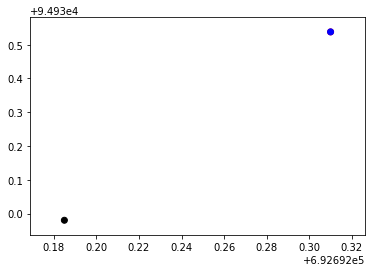

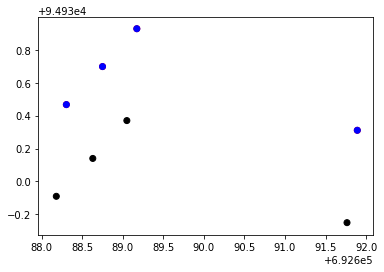

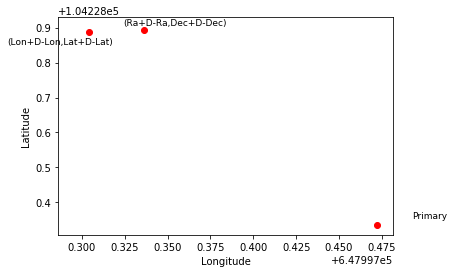

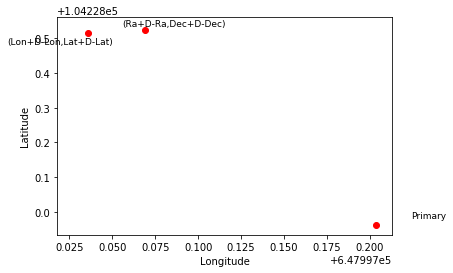

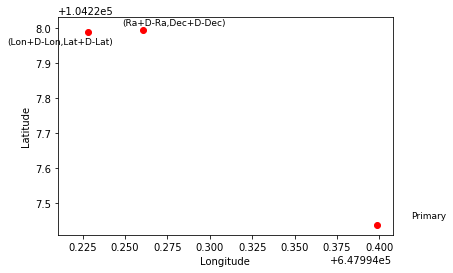

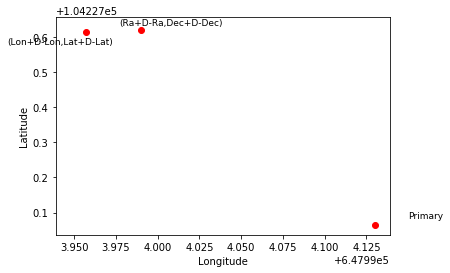

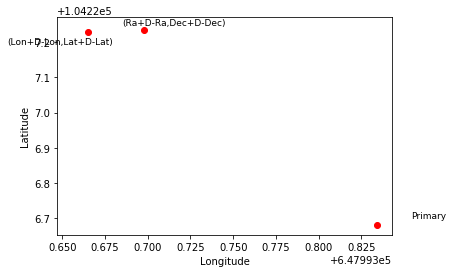

In [385]:
paramsDF = pd.read_csv('GrundyData2.csv')

convert_to_primary_centric(paramsDF,'MakeMake')


In [299]:
def ratodeg(hours, minutes, seconds):
	degrees = 0
	degrees += hours*15.0
	degrees += minutes*0.25
	degrees += seconds*0.004166666667
	return degrees

def dectodeg(degree,minutes,seconds):
	degrees = 0
	degrees += degree
	degrees += minutes/60
	degrees += seconds/3600
	return degrees

print(ratodeg(12,49,39.212))
print(dectodeg(26,22,09.91))

192.41338333334642
26.369419444444446
